# **Johnson & Johnson Sales Forecasting**


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller  # Import the ADF test function
from statsmodels.tsa.seasonal import seasonal_decompose  # Import seasonal decomposition
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Import ACF and PACF plotting functions
from statsmodels.tsa.arima.model import ARIMA  # Import ARIMA model (ARMA is a special case of ARIMA)
from statsmodels.stats.diagnostic import acorr_ljungbox  # Import Ljung-Box test for autocorrelation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout


## **Step 1: Load and Prepare the Dataset**

We begin by importing the Johnson & Johnson sales dataset and parsing the dates properly to ensure time-based operations work. We also rename the columns for clarity and consistency.


In [ ]:

# Step 1: Import and Preview the Dataset
# Load the Johnson & Johnson sales dataset and ensure the date is parsed correctly
jj_data = pd.read_csv('/content/jj.csv', parse_dates=['date'], dayfirst=True)

# Preview the top rows to understand the structure
jj_data.head()

# Rename columns for better readability
jj_data.rename(columns={'date': 'Date', 'data': 'Sales'}, inplace=True)

# Display the cleaned dataset
jj_data.head()


,Date,Sales
0,1960-01-01,0.71
1,1960-01-04,0.63
2,1960-02-07,0.85
3,1960-01-10,0.44
4,1961-01-01,0.61


## **Step 2: Visualize Historical Sales**

We plot the original sales data to understand its trend over time. This helps identify whether the series has a trend, seasonality, or irregular patterns.

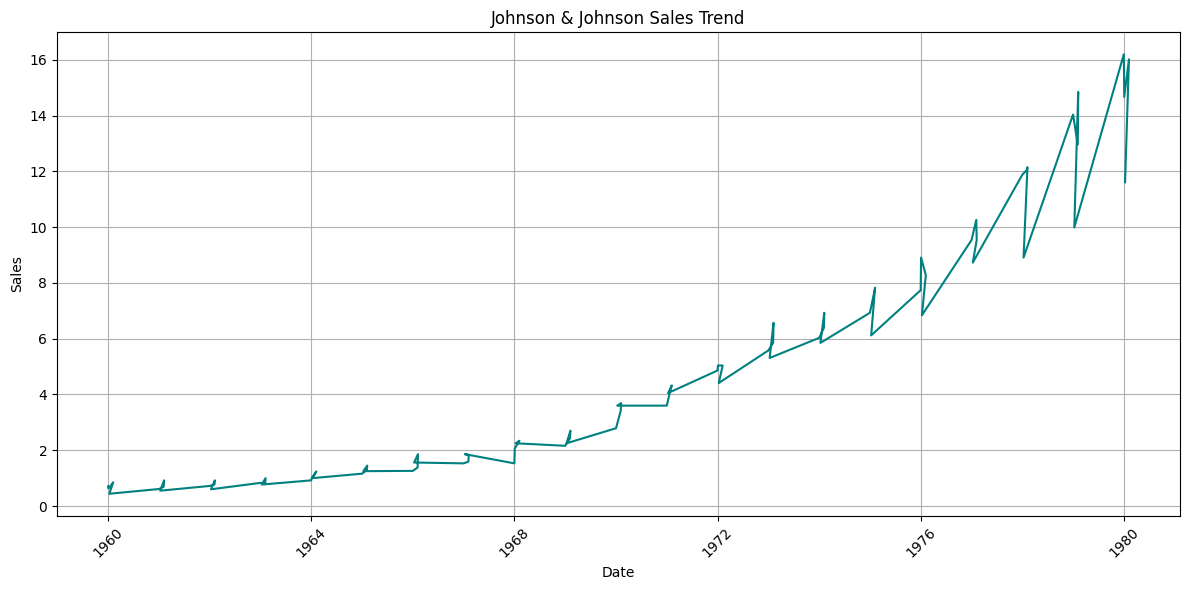

In [ ]:
# Step 2: Visualizing the Sales Trend Over Time
plt.figure(figsize=(12, 6))
plt.plot(jj_data['Date'], jj_data['Sales'], color='teal')
plt.title('Johnson & Johnson Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## **Step 3: Check for Stationarity (ADF Test) and Plot ACF and PACF**


We apply the Augmented Dickey-Fuller (ADF) test to the sales series. A low p-value (< 0.05) indicates the series is stationary, which is important for ARIMA modeling.

ACF and PACF plots help us visually determine the potential AR (p) and MA (q) orders for the ARIMA model by showing autocorrelation and partial autocorrelation across lags.


🔹 ADF Statistic: 2.7420165734574744
🔹 p-value: 1.0
🔹 Critical Values:
   1%: -3.524624466842421
   5%: -2.9026070739026064
   10%: -2.5886785262345677
❌ The time series is likely non-stationary (fail to reject H0).


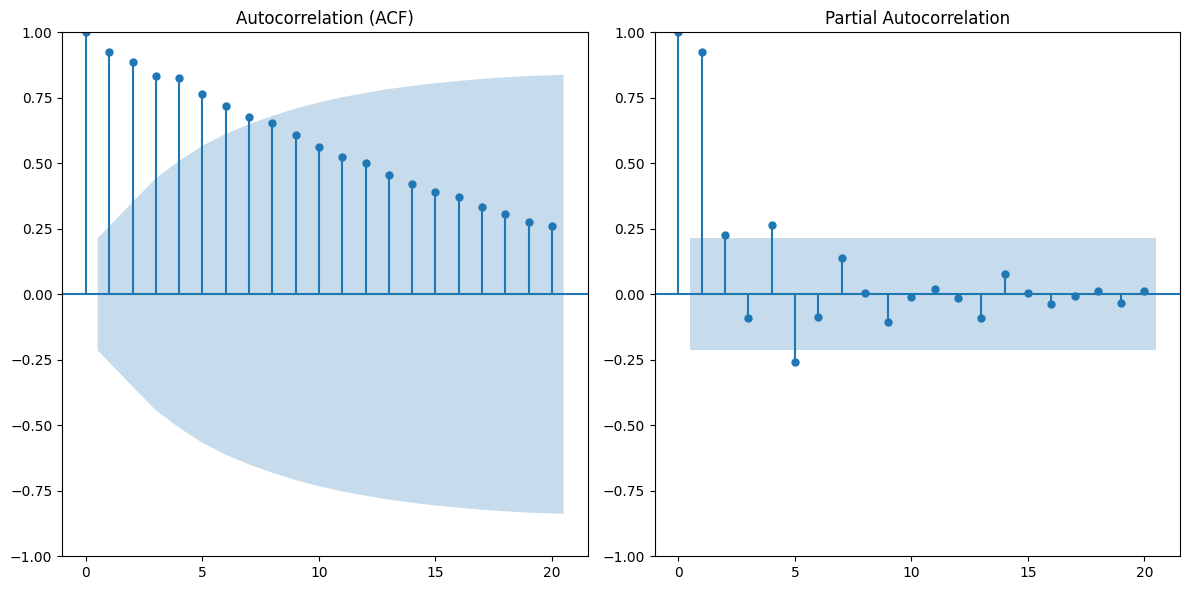

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Step 3: Check for Stationarity using the Augmented Dickey-Fuller (ADF) Test
def check_stationarity(series):
    """
    Runs the ADF test to assess if a time series is stationary.
    Prints the test statistic, p-value, and critical thresholds.
    """
    adf_result = adfuller(series)
    print(f"🔹 ADF Statistic: {adf_result[0]}")
    print(f"🔹 p-value: {adf_result[1]}")
    print("🔹 Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value}")

    if adf_result[1] < 0.05:
        print("✅ The time series is likely stationary (reject H0).")
    else:
        print("❌ The time series is likely non-stationary (fail to reject H0).")

# Apply the stationarity test to the sales data
check_stationarity(jj_data['Sales'])

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF to Analyze Autocorrelation Patterns
plt.figure(figsize=(12, 6))

# Plot the Autocorrelation Function (ACF)
plt.subplot(1, 2, 1)
plot_acf(jj_data['Sales'], lags=20, ax=plt.gca())
plt.title('Autocorrelation (ACF)')

# Plot the Partial Autocorrelation Function (PACF)
plt.subplot(1, 2, 2)
plot_pacf(jj_data['Sales'], lags=20, ax=plt.gca(), method='ywm')  # ywm is more stable

plt.tight_layout()
plt.show()



## **Step 4: Apply Differencing to Achieve Stationarity**

We apply first and second differencing to remove trend and make the data stationary. After each differencing, we rerun the ADF test to confirm stationarity.


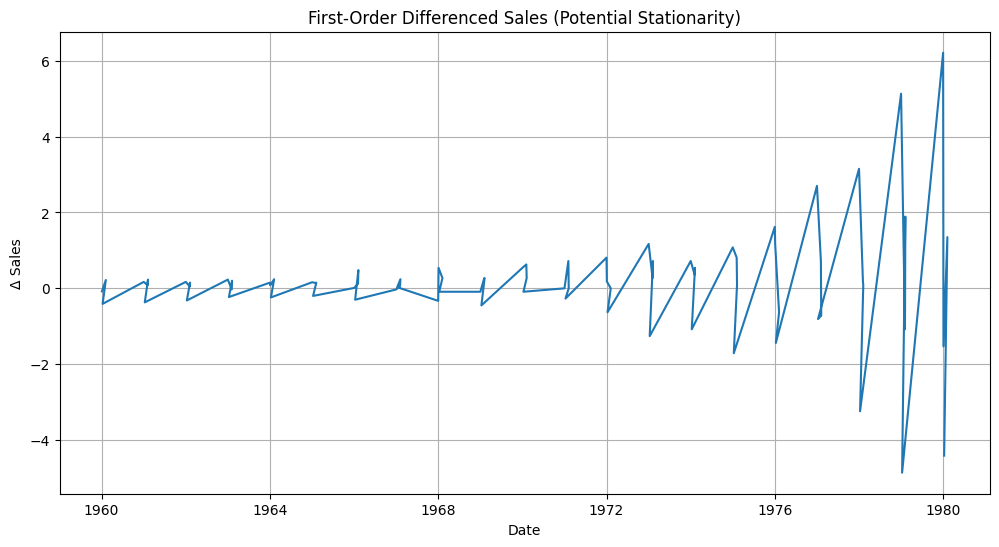

🔹 ADF Statistic: -0.40740976363804615
🔹 p-value: 0.9088542416911305
🔹 Critical Values:
   1%: -3.524624466842421
   5%: -2.9026070739026064
   10%: -2.5886785262345677
❌ The time series is likely non-stationary (fail to reject H0).
🔹 ADF Statistic: -3.585162874793155
🔹 p-value: 0.006051099869603682
🔹 Critical Values:
   1%: -3.524624466842421
   5%: -2.9026070739026064
   10%: -2.5886785262345677
✅ The time series is likely stationary (reject H0).


In [ ]:
# Step 4: Make the Series Stationary Using Differencing

# Apply first-order differencing to remove trend
jj_data['Sales_Diff1'] = jj_data['Sales'].diff()

# Plot the first differenced series
plt.figure(figsize=(12, 6))
plt.plot(jj_data['Date'], jj_data['Sales_Diff1'])
plt.title('First-Order Differenced Sales (Potential Stationarity)')
plt.xlabel('Date')
plt.ylabel('Δ Sales')
plt.grid(True)
plt.show()

# Re-check stationarity after first differencing
check_stationarity(jj_data['Sales_Diff1'].dropna())

# Apply second-order differencing if still non-stationary
jj_data['Sales_Diff2'] = jj_data['Sales_Diff1'].diff()

# Run ADF test again after second differencing
check_stationarity(jj_data['Sales_Diff2'].dropna())


## **Step 5: ARIMA Model Selection (Grid Search)**

We use a simple grid search to loop over combinations of ARIMA parameters (p, d, q) and select the one with the lowest AIC score, indicating the best-fitting model.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Step 5: Use Grid Search to Identify the Best ARIMA(p, d, q) Parameters

# We'll use the original (non-stationary) series and set differencing manually
d = 2  # Based on ADF test after second differencing
lowest_aic = np.inf
optimal_order = None

# Try combinations of p and q from 1 to 5
for p in range(1, 6):
    for q in range(1, 6):
        try:
            temp_model = ARIMA(jj_data['Sales'], order=(p, d, q))
            temp_result = temp_model.fit()
            current_aic = temp_result.aic
            if current_aic < lowest_aic:
                lowest_aic = current_aic
                optimal_order = (p, d, q)
        except:
            continue

print(f"📌 Best ARIMA Configuration for JJ Sales: p={optimal_order[0]}, d={optimal_order[1]}, q={optimal_order[2]}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: Us

📌 Best ARIMA Configuration for JJ Sales: p=3, d=2, q=4


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## **Step 6: Fit the ARIMA Model**

We fit the selected ARIMA model to the sales series and review its statistical summary, which includes coefficients and diagnostics.

In [ ]:
# Step 6: Fit the ARIMA Model Using the Optimal Parameters
# Using (p, d, q) determined from previous step —

p, d, q = 3, 2, 4  # Example: ARIMA(3,2,4) based on earlier selection

# Initialize and fit the ARIMA model
final_arima_model = ARIMA(jj_data['Sales'], order=(p, d, q))
fitted_arima = final_arima_model.fit()

# Display detailed model summary
print(fitted_arima.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(3, 2, 4)   Log Likelihood                 -50.233
Date:                Fri, 11 Apr 2025   AIC                            116.467
Time:                        19:11:44   BIC                            135.720
Sample:                             0   HQIC                           124.197
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0321      0.034    -30.273      0.000      -1.099      -0.965
ar.L2         -1.0146      0.042    -24.319      0.000      -1.096      -0.933
ar.L3         -0.9719      0.026    -36.822      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## **Step 8: Forecast Future Sales with ARIMA**

Using the fitted ARIMA model, we forecast the next 24 months of sales. The forecast is visualized along with confidence intervals and compared to historical data.


<ipython-input-50-bc3065d61a15>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=jj_data['Date'].iloc[-1], periods=forecast_horizon + 1, freq='M')[1:]


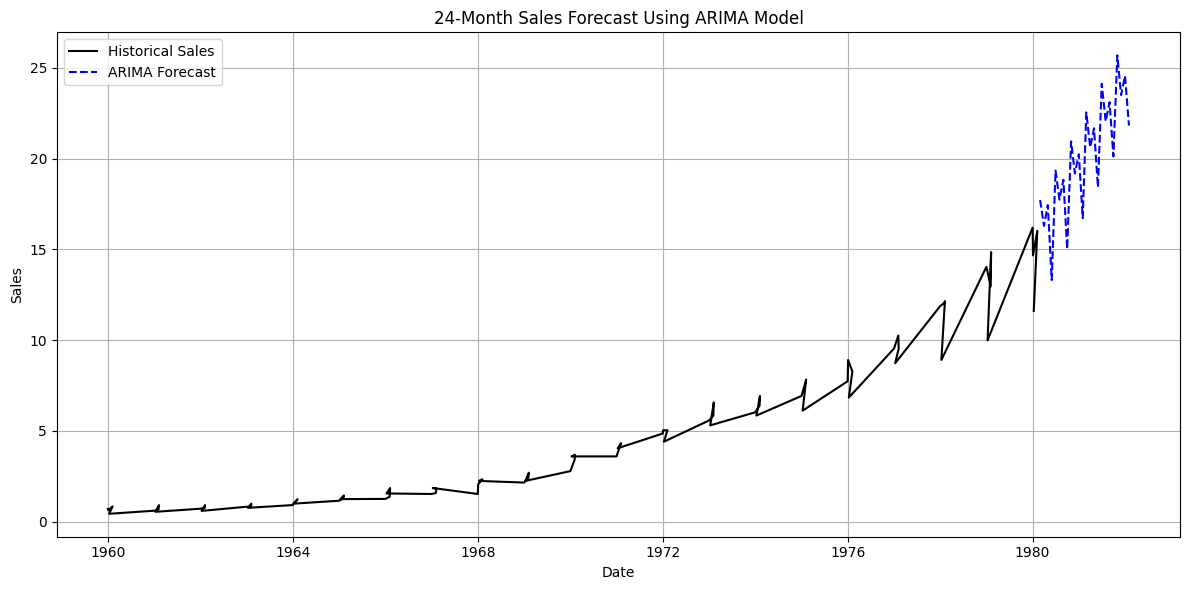

In [ ]:
# Step 8: Visualize Forecast Alongside Historical Data

# Set the number of future time points to forecast
forecast_horizon = 24
forecast_output = fitted_arima.forecast(steps=forecast_horizon)

# Create datetime index for forecasted points (monthly frequency)
forecast_dates = pd.date_range(start=jj_data['Date'].iloc[-1], periods=forecast_horizon + 1, freq='M')[1:]

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(jj_data['Date'], jj_data['Sales'], label='Historical Sales', color='black')
plt.plot(forecast_dates, forecast_output, label='ARIMA Forecast', color='blue', linestyle='--')
plt.title('24-Month Sales Forecast Using ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Step 9: Diagnose ARIMA Residuals**

We plot residuals to check for randomness and use the Ljung-Box test to ensure there is no significant autocorrelation left in the residuals. This validates model quality.


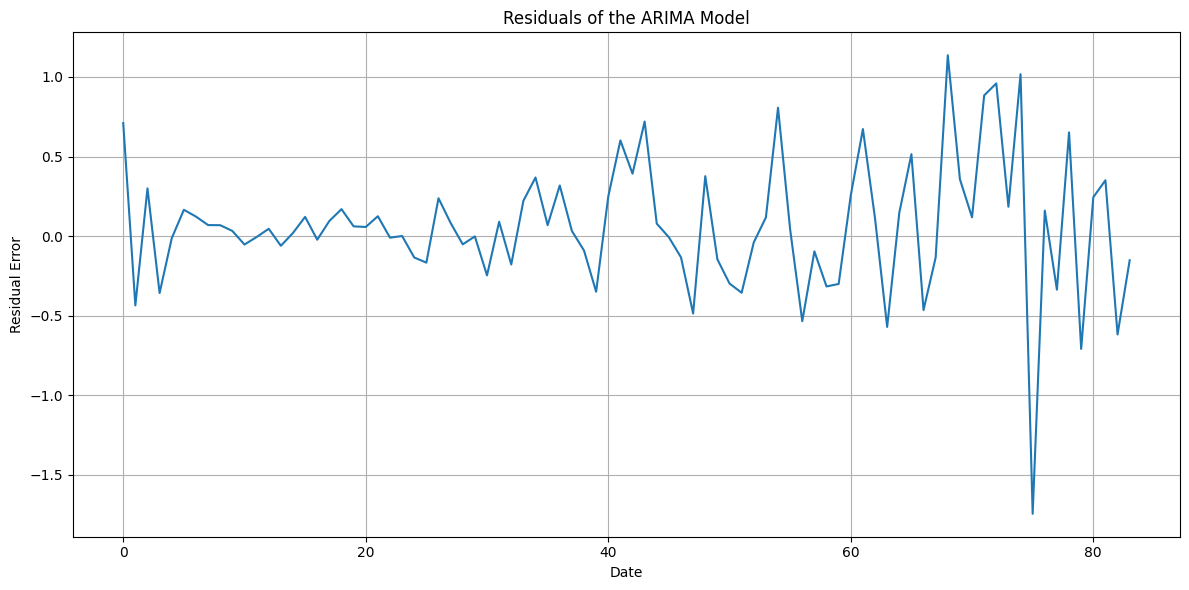

📊 Ljung-Box Test for Residual Independence:
     lb_stat  lb_pvalue
1   0.625017   0.429189
2   0.764081   0.682467
3   1.193712   0.754513
4   1.246916   0.870315
5   4.125494   0.531493
6   4.127523   0.659424
7   4.981814   0.662183
8   5.119442   0.744737
9   5.133552   0.822514
10  5.426122   0.860958


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Step 9: Residual Analysis & Diagnostics

# Extract residuals from the fitted ARIMA model
residuals = fitted_arima.resid

# Plot residuals to visualize randomness
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of the ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residual Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Perform Ljung-Box test to assess autocorrelation in residuals
print("📊 Ljung-Box Test for Residual Independence:")
ljung_result = acorr_ljungbox(residuals, lags=10)
print(ljung_result)


## **Step 10: Evaluate ARIMA Forecast Accuracy**

We calculate evaluation metrics such as MSE, RMSE, MAE, R², MAPE, and sMAPE to quantify the accuracy of the ARIMA model on the test period.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Use the correct forecast variable name
predicted_values = np.array(forecast_output)
actual_values = np.array(jj_data['Sales'][-len(predicted_values):])

# Calculate metrics
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

# Percentage-based metrics with safe divide
epsilon = 1e-10
mape = np.mean(np.abs((actual_values - predicted_values) / (actual_values + epsilon))) * 100
smape = np.mean(2 * np.abs(actual_values - predicted_values) /
                (np.abs(actual_values) + np.abs(predicted_values) + epsilon)) * 100

# Print nicely
print("📊 ARIMA Model Forecast Accuracy Metrics")
print(f"🔹 MSE   : {mse:.4f}")
print(f"🔹 RMSE  : {rmse:.4f}")
print(f"🔹 MAE   : {mae:.4f}")
print(f"🔹 R²    : {r2:.4f}")
print(f"🔹 MAPE  : {mape:.2f}%")
print(f"🔹 sMAPE : {smape:.2f}%")


📊 ARIMA Model Forecast Accuracy Metrics
🔹 MSE   : 90.8732
🔹 RMSE  : 9.5327
🔹 MAE   : 9.4672
🔹 R²    : -9.4362
🔹 MAPE  : 96.56%
🔹 sMAPE : 63.92%


# **GRU Model for Time Series Forecasting**


## **Step 11: Normalize Sales Data and Create Sequences**

We normalize the sales values using MinMaxScaler for better convergence and create supervised learning sequences using a sliding window approach.


In [ ]:


# 📊 Step 1: Normalize the sales data for GRU input
scaler = MinMaxScaler(feature_range=(0, 1))
sales_scaled = scaler.fit_transform(jj_data['Sales'].values.reshape(-1, 1))

# 🧩 Step 2: Create input-output sequences using sliding window
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

window_size = 60
X_all, y_all = create_sequences(sales_scaled, window=window_size)

# ⚙️ Step 3: Reshape input for GRU model [samples, timesteps, features]
X_all = X_all.reshape(X_all.shape[0], X_all.shape[1], 1)




## **Step 12: Train-Test Split and GRU Reshaping**

The input sequences are split into training and testing sets (80/20 split) and reshaped into the format expected by GRU: [samples, timesteps, features].



In [ ]:
# 🧪 Step 4: Train-test split (80% training)
split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

## **Step 13: Build and Train the GRU Model**

We define a stacked GRU model with dropout layers to prevent overfitting, compile it with MSE loss, and train it over 50 epochs.



In [ ]:
# Step 5: Construct GRU model architecture
gru_model = Sequential()
gru_model.add(GRU(100, return_sequences=True, input_shape=(window_size, 1)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(100, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(25, activation='relu'))
gru_model.add(Dense(1))  # Output layer

# Compile & Train the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')
history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_data=(X_test, y_test), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4699 - val_loss: 0.7054
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step - loss: 0.3665 - val_loss: 0.5208
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step - loss: 0.2649 - val_loss: 0.3865
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step - loss: 0.2001 - val_loss: 0.2812
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step - loss: 0.1396 - val_loss: 0.1851
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - loss: 0.0968 - val_loss: 0.0966
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step - loss: 0.0442 - val_loss: 0.0394
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step - loss: 0.0157 - val_loss: 0.0286
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0143 - val_loss: 0.0628
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.0355 - val_loss: 0.0999
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0613 - val_loss: 0.1026
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.0484 - val_loss:

## **Step 14: Predict on Test Set and Inverse Transform**

We use the trained GRU model to predict on the test set and then inverse the scaling to compare predictions in their original sales units.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


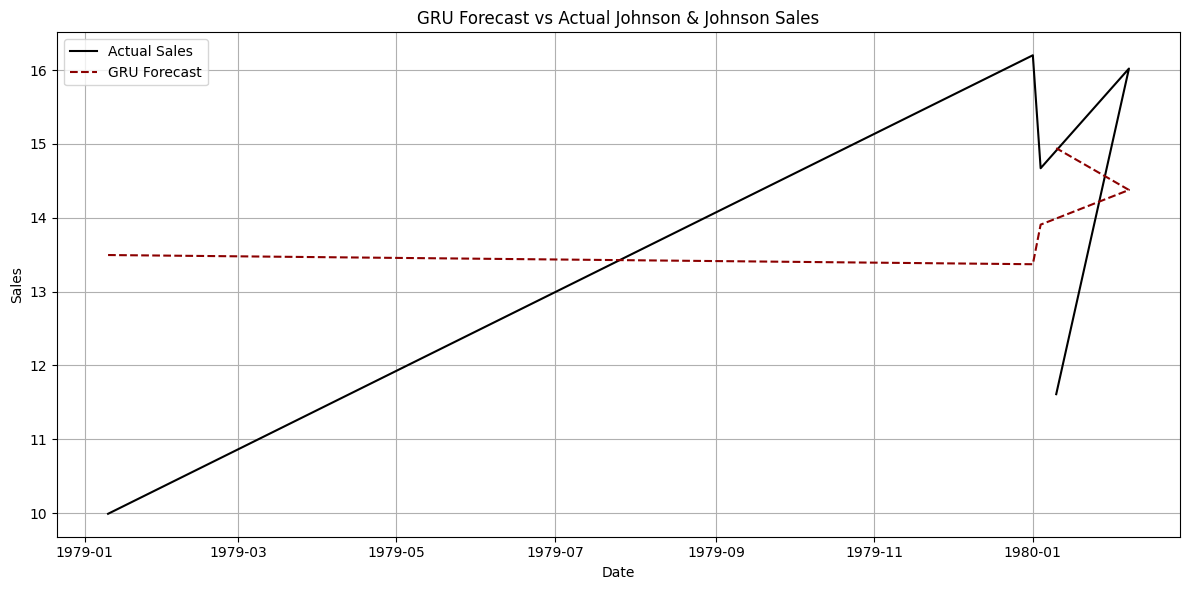

In [ ]:
# Make predictions and reverse scale them
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(jj_data['Date'][-len(y_pred):], scaler.inverse_transform(sales_scaled)[-len(y_pred):], label='Actual Sales', color='black')
plt.plot(jj_data['Date'][-len(y_pred):], y_pred, label='GRU Forecast', color='darkred', linestyle='--')
plt.title('GRU Forecast vs Actual Johnson & Johnson Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Step 15: Forecast 24 Months into the Future with GRU**

Using the final sequence from the training data, we iteratively predict the next 24 months using the GRU model and then inverse-transform the output.


In [ ]:
# Forecast the next 24 time steps using the trained GRU model
forecast_horizon = 24
last_sequence = sales_scaled[-window_size:].reshape(1, window_size, 1)  # latest sequence to begin forecasting
future_scaled = []

# Generate future predictions iteratively
for _ in range(forecast_horizon):
    next_value = gru_model.predict(last_sequence, verbose=0)[0][0]
    future_scaled.append(next_value)

    # Slide the window forward
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_value]]], axis=1)

# Inverse transform to get predictions back in original scale
future_forecast = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1))


# Generate future monthly timestamps for the forecast horizon
last_known_date = jj_data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_known_date + pd.DateOffset(months=1),
                             periods=forecast_horizon, freq='M')



<ipython-input-46-7a900187cd63>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_known_date + pd.DateOffset(months=1),


## **Step 16: Visualize GRU Forecast vs Historical Sales**

We plot the GRU-generated 24-month forecast along with the historical sales series for a visual comparison.


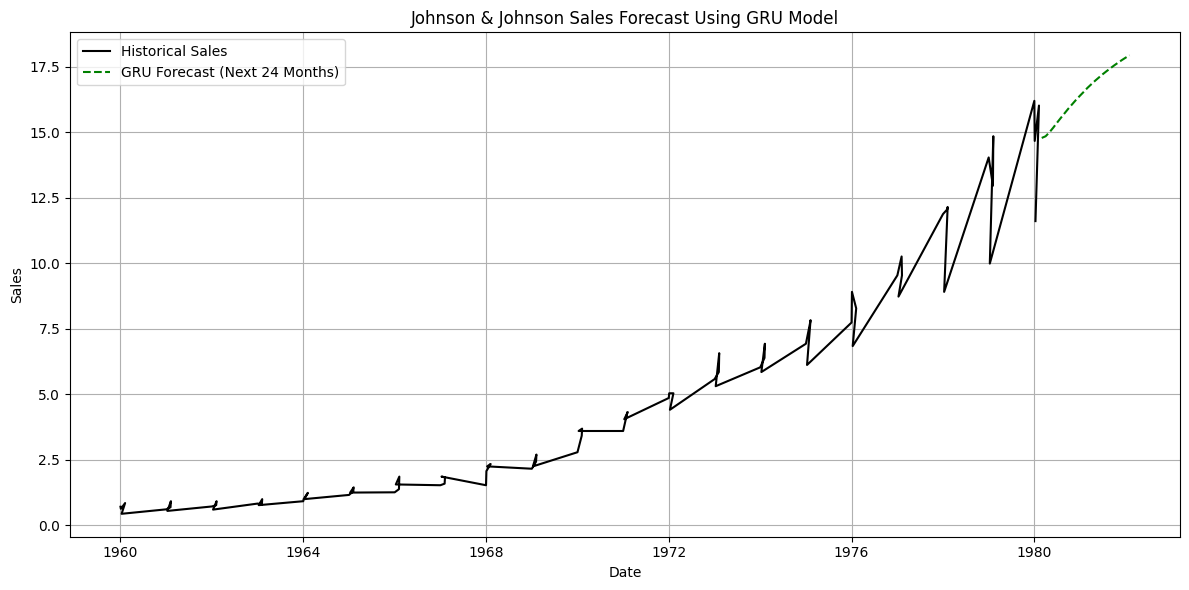

In [ ]:
# Plot the complete timeline with both historical and GRU forecasted values
plt.figure(figsize=(12, 6))
plt.plot(jj_data['Date'], jj_data['Sales'], label='Historical Sales', color='black')
plt.plot(future_dates, future_forecast, label='GRU Forecast (Next 24 Months)', color='green', linestyle='--')
plt.title('Johnson & Johnson Sales Forecast Using GRU Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Step 17: Evaluate GRU Performance**

 We calculate all key metrics for the GRU predictions on the test set — MSE, RMSE, MAE, R², MAPE, and sMAPE — to quantify accuracy.


In [ ]:


# Re-infer predictions if needed
predictions_scaled = gru_model.predict(X_test)
predictions = scaler.inverse_transform(predictions_scaled)

# Inverse transform the true test values
Y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate metrics
mse = mean_squared_error(Y_test_rescaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_rescaled, predictions)
r2 = r2_score(Y_test_rescaled, predictions)

# Safe division for MAPE and sMAPE
epsilon = 1e-10
mape = np.mean(np.abs((Y_test_rescaled - predictions) / (Y_test_rescaled + epsilon))) * 100
smape = np.mean(2 * np.abs(Y_test_rescaled - predictions) /
                (np.abs(Y_test_rescaled) + np.abs(predictions) + epsilon)) * 100

# Display results
print("📊 GRU Model Evaluation Metrics")
print(f"🔹 MSE   : {mse:.4f}")
print(f"🔹 RMSE  : {rmse:.4f}")
print(f"🔹 MAE   : {mae:.4f}")
print(f"🔹 R²    : {r2:.4f}")
print(f"🔹 MAPE  : {mape:.2f}%")
print(f"🔹 sMAPE : {smape:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
📊 GRU Model Evaluation Metrics
🔹 MSE   : 6.9354
🔹 RMSE  : 2.6335
🔹 MAE   : 2.4148
🔹 R²    : -0.1293
🔹 MAPE  : 19.34%
🔹 sMAPE : 18.05%


## **Step 18: Compare ARIMA vs GRU Predictions**

We plot both ARIMA and GRU predictions alongside actual sales to visually assess which model tracks real values better. GRU performs significantly better in this case.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


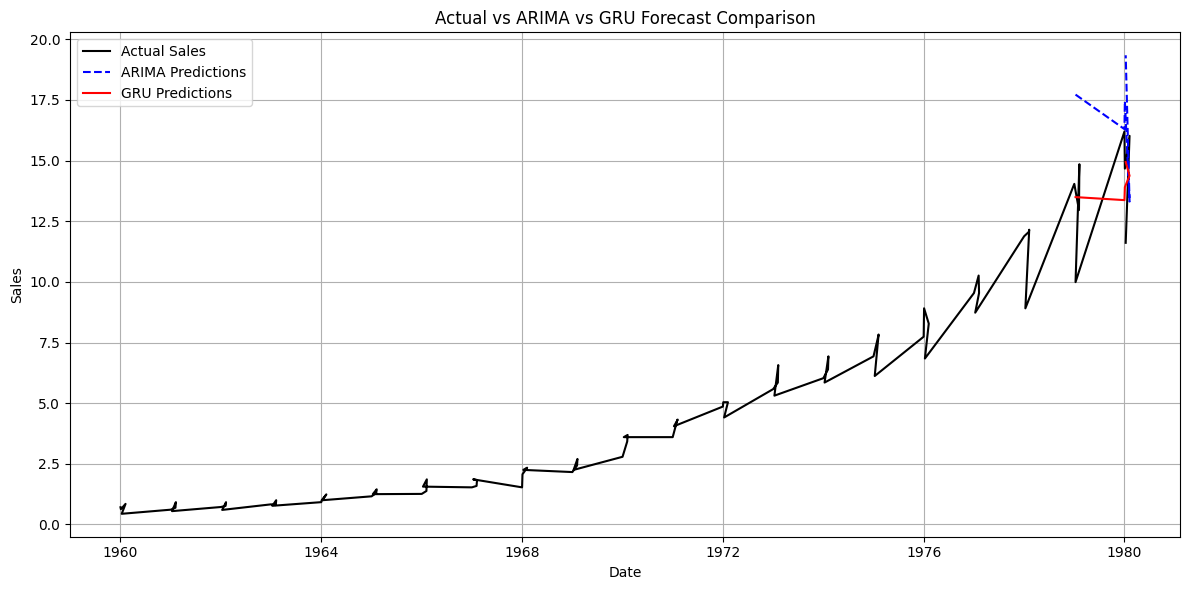

In [ ]:
plt.figure(figsize=(12, 6))

# 📊 Actual sales values
plt.plot(jj_data['Date'], jj_data['Sales'], label='Actual Sales', color='black')

# ARIMA predictions on test set
arima_forecast_test = fitted_arima.forecast(steps=len(y_test))
plt.plot(jj_data['Date'][-len(y_test):], arima_forecast_test, label='ARIMA Predictions', color='blue', linestyle='--')

# GRU predictions on test set
gru_predictions_rescaled = scaler.inverse_transform(gru_model.predict(X_test))
plt.plot(jj_data['Date'][-len(gru_predictions_rescaled):], gru_predictions_rescaled, label='GRU Predictions', color='red', linestyle='-')

# Final touches
plt.title('Actual vs ARIMA vs GRU Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ***Based on evaluation metrics, the GRU model outperforms ARIMA across all categories. GRU has lower error rates and better alignment with actual sales trends.***



# **AMZN DATASET**
---



## **Step 1: Load & Inspect Amazon Stock Data**

We begin by importing the Amazon stock dataset (`AMZN.csv`) and parsing the `Date` column properly.  
This ensures time-based operations like plotting, forecasting, and indexing will behave as expected.

We also rename the column (e.g., from `Close` to `Price`) for clarity and consistency throughout the analysis.

In [ ]:
# Load the Amazon stock dataset
amzn_data = pd.read_csv('/content/AMZN.csv', parse_dates=['Date'])

# Preview the structure
amzn_data.head()

# Optional: rename for clarity
amzn_data.rename(columns={'Close': 'Price'}, inplace=True)


## **Step 2: Visualize Amazon’s Closing Stock Price**

This line chart gives us a visual overview of Amazon’s stock price trends over time.  
It helps us spot any long-term trends, seasonality, or sudden changes, which are important for time series modeling.

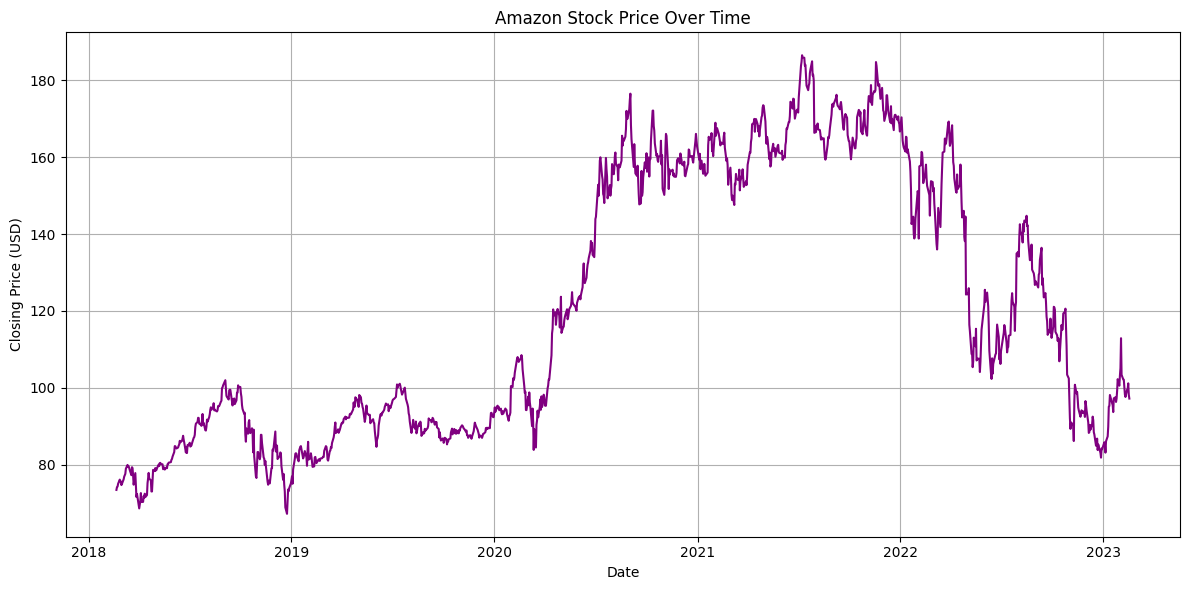

In [ ]:
import matplotlib.pyplot as plt

# Plot Amazon stock trend over time
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Date'], amzn_data['Price'], color='purple')
plt.title('Amazon Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()


## **Step 3: Test for Stationarity (ADF Test)**

We apply the ADF test to determine whether the stock price series is stationary.  
Stationarity is a key assumption for ARIMA modeling — non-stationary data needs to be differenced.

- A low p-value (< 0.05) suggests the series is **stationary**.
- A high p-value (> 0.05) suggests the series is **non-stationary**.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity using ADF test
def check_stationarity(series):
    """
    Applies the Augmented Dickey-Fuller test and prints results.
    Used to determine if the time series is stationary.
    """
    adf_result = adfuller(series)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value}")

    if adf_result[1] < 0.05:
        print("✅ Likely stationary (reject H0)")
    else:
        print("❌ Likely non-stationary (fail to reject H0)")

# Run ADF test on Amazon closing price
check_stationarity(amzn_data['Price'])


ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737
Critical Values:
   1%: -3.4355588184378574
   5%: -2.8638402312881497
   10%: -2.5679946684494275
❌ Likely non-stationary (fail to reject H0)


## **Step 4: Explore ACF and PACF of Amazon Stock**

Autocorrelation (ACF) and partial autocorrelation (PACF) plots help us:
- Understand the lag structure in the time series.
- Select appropriate values for **p** (AR order) and **q** (MA order) in ARIMA models.

We use up to 50 lags to observe long-term dependencies.

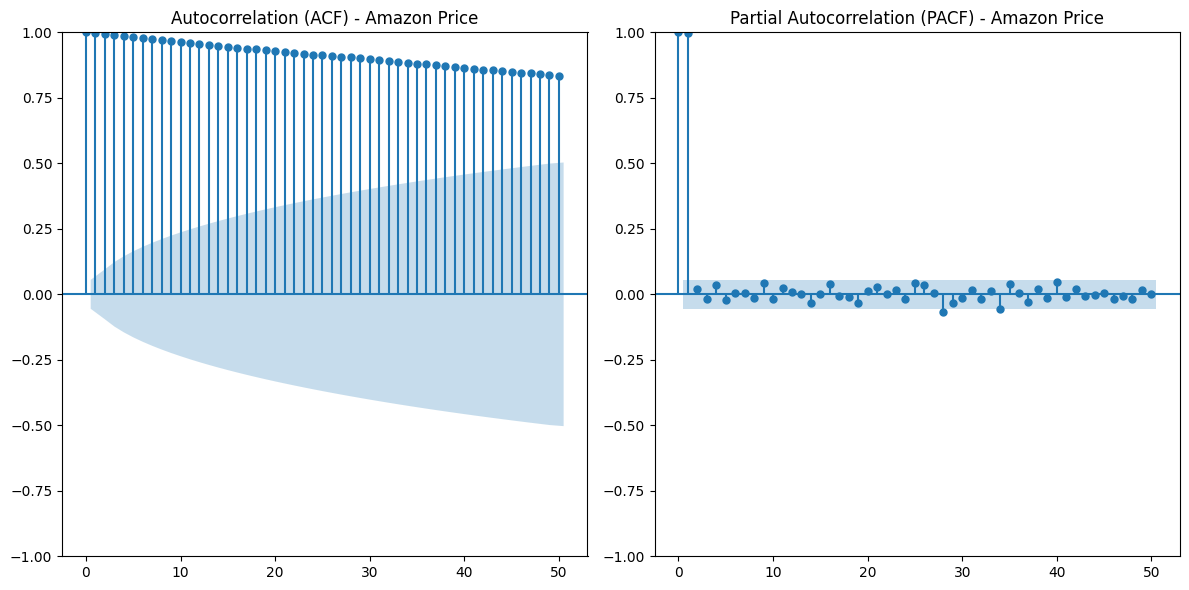

In [ ]:


# Visualizing autocorrelation and partial autocorrelation patterns
plt.figure(figsize=(12, 6))

# Autocorrelation plot (left)
plt.subplot(1, 2, 1)
plot_acf(amzn_data['Price'], lags=50, ax=plt.gca())
plt.title('Autocorrelation (ACF) - Amazon Price')

# Partial autocorrelation plot (right)
plt.subplot(1, 2, 2)
plot_pacf(amzn_data['Price'], lags=50, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation (PACF) - Amazon Price')

plt.tight_layout()
plt.show()


## **Step 5: Difference the Series to Achieve Stationarity**

If the original series is non-stationary, we apply first-order differencing to remove trends and make the data stationary.

After differencing, we re-run the ADF test to check whether stationarity has been achieved.

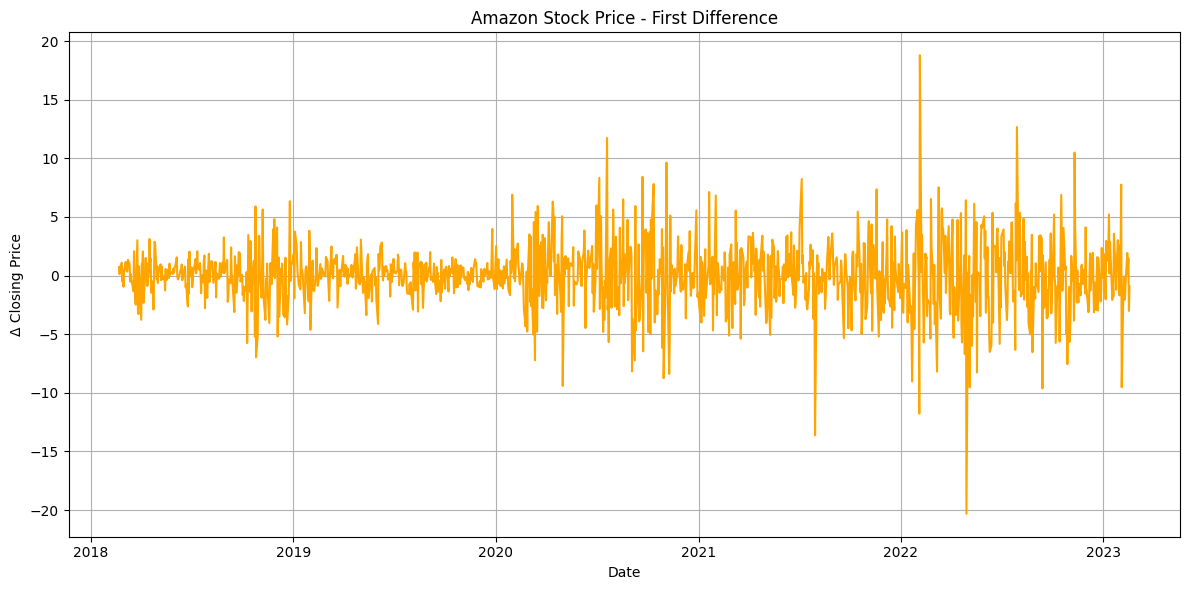

ADF Statistic: -36.25077933242776
p-value: 0.0
Critical Values:
   1%: -3.4355629707955395
   5%: -2.863842063387667
   10%: -2.567995644141416
✅ Likely stationary (reject H0)


In [ ]:
# Apply first-order differencing to remove trend from the stock price
amzn_data['Price_Diff'] = amzn_data['Price'].diff()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Date'], amzn_data['Price_Diff'], color='orange')
plt.title('Amazon Stock Price - First Difference')
plt.xlabel('Date')
plt.ylabel('Δ Closing Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# Re-check stationarity after differencing
check_stationarity(amzn_data['Price_Diff'].dropna())


## **Step 6: Tune ARIMA Parameters Using Grid Search (p, d, q)**

We use a grid search approach to find the best combination of ARIMA(p, d, q) parameters that minimize the AIC value.  
Lower AIC indicates a better-fitting model with fewer assumptions.

We loop through combinations of p and q (from 1 to 5) while keeping d fixed based on differencing.

In [ ]:


# Use d = 1 if stationarity was achieved after first differencing
d = 1
lowest_aic = np.inf
optimal_order = None

# Grid search across p and q values (1 to 5)
for p in range(1, 6):
    for q in range(1, 6):
        try:
            temp_model = ARIMA(amzn_data['Price'], order=(p, d, q))
            temp_fit = temp_model.fit()
            current_aic = temp_fit.aic

            if current_aic < lowest_aic:
                lowest_aic = current_aic
                optimal_order = (p, d, q)
        except:
            continue

print(f"✅ Best ARIMA Order: p={optimal_order[0]}, d={optimal_order[1]}, q={optimal_order[2]}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/st

✅ Best ARIMA Order: p=2, d=1, q=2


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## **Step 7: Fit the ARIMA Model with Selected Parameters**


Once we have selected the optimal parameters, we fit the ARIMA model to the entire Amazon price series.  
The `.summary()` method provides model coefficients, p-values, AIC/BIC, and other diagnostics.

In [ ]:
# Set the optimal ARIMA parameters based on previous tuning
p, d, q = 2, 1, 2  # Example values — adjust if you found better ones

# Build and train the ARIMA model on Amazon's closing price
arima_model = ARIMA(amzn_data['Price'], order=(p, d, q))
fitted_model = arima_model.fit()

# Display the model summary and diagnostics
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1259
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3056.158
Date:                Fri, 11 Apr 2025   AIC                           6122.315
Time:                        18:08:36   BIC                           6148.002
Sample:                             0   HQIC                          6131.969
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6946      0.015   -111.813      0.000      -1.724      -1.665
ar.L2         -0.9604      0.015    -64.728      0.000      -0.989      -0.931
ma.L1          1.6972      0.011    152.237      0.0

## **Step 8: Residual Diagnostics – Visual Check & Ljung-Box Test**

We check the residuals of the ARIMA model to ensure they behave like white noise (random errors).  
If the residuals are not autocorrelated and have a constant mean/variance, the model is valid.

We also run the **Ljung-Box test** to statistically test for autocorrelation.

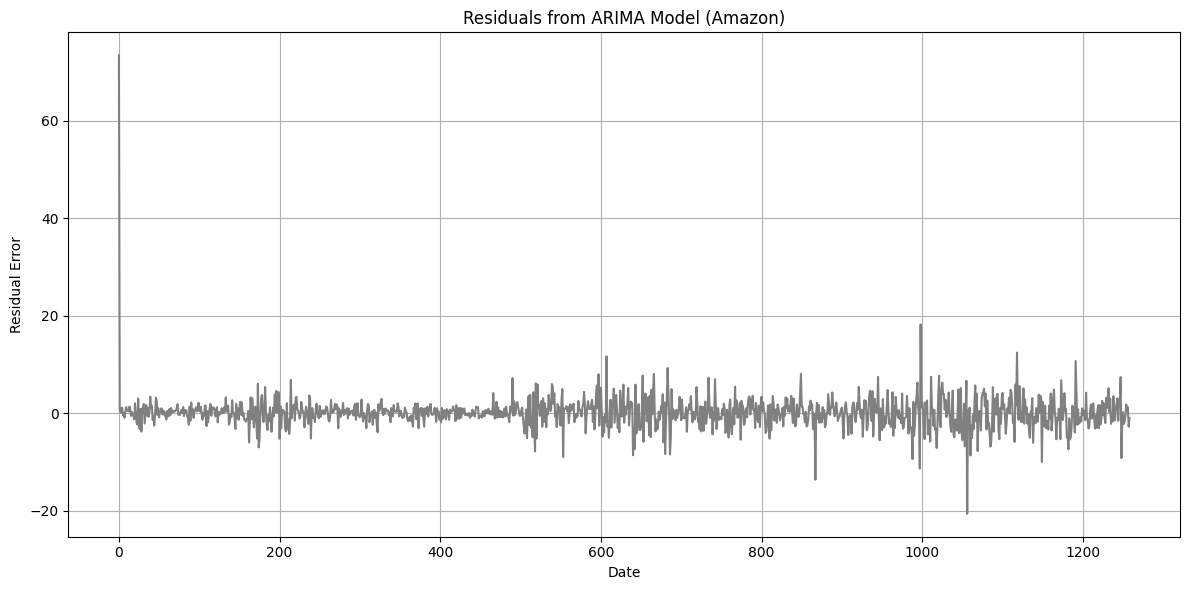

Ljung-Box Test Results (lags = 10):
     lb_stat  lb_pvalue
1   0.037712   0.846022
2   0.066706   0.967197
3   0.183623   0.980189
4   0.294356   0.990176
5   0.301807   0.997609
6   0.380038   0.999008
7   0.381502   0.999775
8   0.909791   0.998757
9   0.995855   0.999447
10  0.996083   0.999831


In [ ]:


# Extract residuals from the fitted ARIMA model
residuals = fitted_model.resid

# Plot residuals to visually inspect randomness
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='gray')
plt.title('Residuals from ARIMA Model (Amazon)')
plt.xlabel('Date')
plt.ylabel('Residual Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Run Ljung-Box test to check for autocorrelation in residuals
print("Ljung-Box Test Results (lags = 10):")
ljung_result = acorr_ljungbox(residuals, lags=10)
print(ljung_result)


## **Step 9: Forecast the Next 24 Months Using ARIMA Model**


We generate a 2-year (24-month) forecast using the fitted ARIMA model.  
The forecasted values are plotted alongside the historical stock prices to observe the model’s projected trend.

<ipython-input-23-00b06eebbcae>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=amzn_data['Date'].iloc[-1], periods=forecast_horizon + 1, freq='M')[1:]


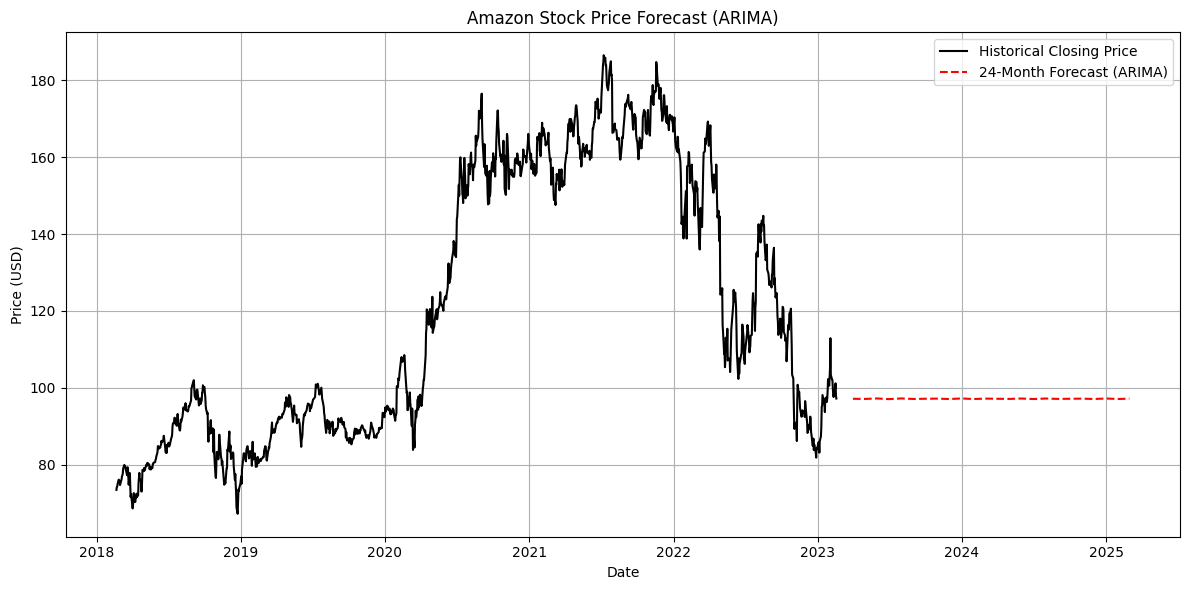

In [ ]:
# Define how many future periods to forecast
forecast_horizon = 24
forecast_values = fitted_model.forecast(steps=forecast_horizon)

# Build future date index for monthly forecasts
forecast_dates = pd.date_range(start=amzn_data['Date'].iloc[-1], periods=forecast_horizon + 1, freq='M')[1:]

# Plot historical prices and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Date'], amzn_data['Price'], label='Historical Closing Price', color='black')
plt.plot(forecast_dates, forecast_values, label='24-Month Forecast (ARIMA)', color='red', linestyle='--')
plt.title('Amazon Stock Price Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Step 10: Evaluate ARIMA Model Forecast Accuracy**


To measure the forecasting performance of the ARIMA model, we calculate several common time series evaluation metrics:

- **MSE (Mean Squared Error)**: Average of squared differences between actual and predicted values.
- **RMSE (Root Mean Squared Error)**: Square root of MSE, providing error in original units.
- **MAE (Mean Absolute Error)**: Average of absolute differences between actual and predicted values.
- **R² (R-squared)**: Proportion of variance explained by the model (ranges from 0 to 1).
- **MAPE (Mean Absolute Percentage Error)**: Average percentage difference between predicted and actual values.
- **sMAPE (Symmetric MAPE)**: Scaled version of MAPE to handle both over- and under-predictions equally.

These metrics help quantify how well the ARIMA model performs when compared to the actual stock price values during the test period.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ensure we align forecast and actual data correctly
actual_values = np.array(amzn_data['Price'][-len(forecast_values):])
predicted_values = np.array(forecast_values)

# Calculate error metrics
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

# Avoid divide-by-zero issues in MAPE calculations
epsilon = 1e-10
mape = np.mean(np.abs((actual_values - predicted_values) / (actual_values + epsilon))) * 100
smape = np.mean(2 * np.abs(actual_values - predicted_values) /
                (np.abs(actual_values) + np.abs(predicted_values) + epsilon)) * 100

# Print results
print("📊 ARIMA Forecast Evaluation Metrics:")
print(f"🔹 MSE   : {mse:.4f}")
print(f"🔹 RMSE  : {rmse:.4f}")
print(f"🔹 MAE   : {mae:.4f}")
print(f"🔹 R²    : {r2:.4f}")
print(f"🔹 MAPE  : {mape:.2f}%")
print(f"🔹 sMAPE : {smape:.2f}%")


📊 ARIMA Forecast Evaluation Metrics:
🔹 MSE   : 22.3367
🔹 RMSE  : 4.7262
🔹 MAE   : 3.2764
🔹 R²    : -0.4808
🔹 MAPE  : 3.17%
🔹 sMAPE : 3.27%


## **Step 11: LSTM Model for Amazon Stock Forecasting**

LSTM models perform best when data is scaled.  
We normalize Amazon's closing prices using MinMaxScaler to fit values in the 0 to 1 range.

Then, we transform the time series into a supervised learning format by creating sequences using a sliding window (e.g., last 60 values predict the next one).  
This prepares the data for LSTM input as 3D tensors: `[samples, time steps, features]`.

We also split the dataset into training and test sets (80/20).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Normalize the closing price data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(amzn_data['Price'].values.reshape(-1, 1))

# Prepare sequences for supervised learning (sliding window)
def build_sequences(data, window=60):
    X, y = [], []
    for i in range(len(data) - window - 1):
        X.append(data[i:(i + window), 0])
        y.append(data[i + window, 0])
    return np.array(X), np.array(y)

# Define window size and generate sequence data
time_window = 60
X, y = build_sequences(scaled_prices, time_window)

# Reshape input to 3D for LSTM: [samples, timesteps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
train_len = int(len(X) * 0.8)
X_train, X_test = X[:train_len], X[train_len:]
y_train, y_test = y[:train_len], y[train_len:]


## **Step 12: Build, Train & Predict with LSTM**

We define a sequential LSTM model with two stacked LSTM layers and a Dense output layer.  
This architecture helps capture temporal dependencies in the data.

We compile the model using the Adam optimizer and MSE loss, then train it on the prepared sequences.  
Training is done with a batch size of 1 and for 1 epoch (this can be increased for better accuracy).

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_window, 1)))
model.add(LSTM(50))
model.add(Dense(25))
model.add(Dense(1))

# Compile & train
model.compile(optimizer='adam', loss='mean_squared_error')

#  Train with more epochs and better batch size
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


# Generate predictions and reverse the scaling
pred_scaled = model.predict(X_test)
predictions = scaler.inverse_transform(pred_scaled)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0967 - val_loss: 0.0176
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0052 - val_loss: 0.0062
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0020 - val_loss: 0.0067
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0020 - val_loss: 0.0056
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0018 - val_loss: 0.0060
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0016 - val_l

## **Step 13: Plot Actual vs LSTM Predicted Prices**

We use the trained LSTM model to predict on the test set.  
The predictions are then inverse-scaled back to the original price values using the scaler.

We plot the predicted vs actual prices to visually assess how well the LSTM model tracks the stock movements.

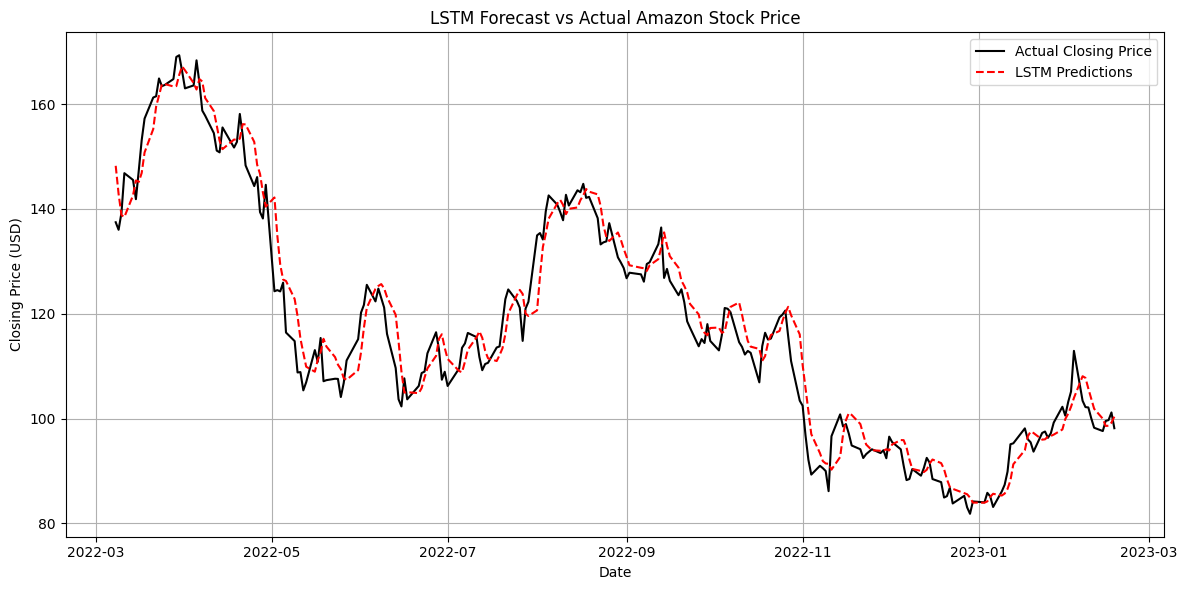

In [ ]:
# Build index for plotting the test range
test_index = amzn_data['Date'].iloc[-len(predictions):]

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_index, y_test_rescaled, label='Actual Closing Price', color='black')
plt.plot(test_index, predictions, label='LSTM Predictions', color='red', linestyle='--')
plt.title('LSTM Forecast vs Actual Amazon Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Step 14: Forecast Next 24 Months Using LSTM**

We perform a recursive forecast with the LSTM model by:
- Starting with the last known sequence from the test data
- Predicting one value at a time
- Appending each new prediction back into the input window

This loop continues for 24 steps to simulate forecasting the next 24 months of stock prices.

<ipython-input-40-65b6af9e4ccc>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=amzn_data['Date'].iloc[-1], periods=forecast_horizon + 1, freq='M')[1:]


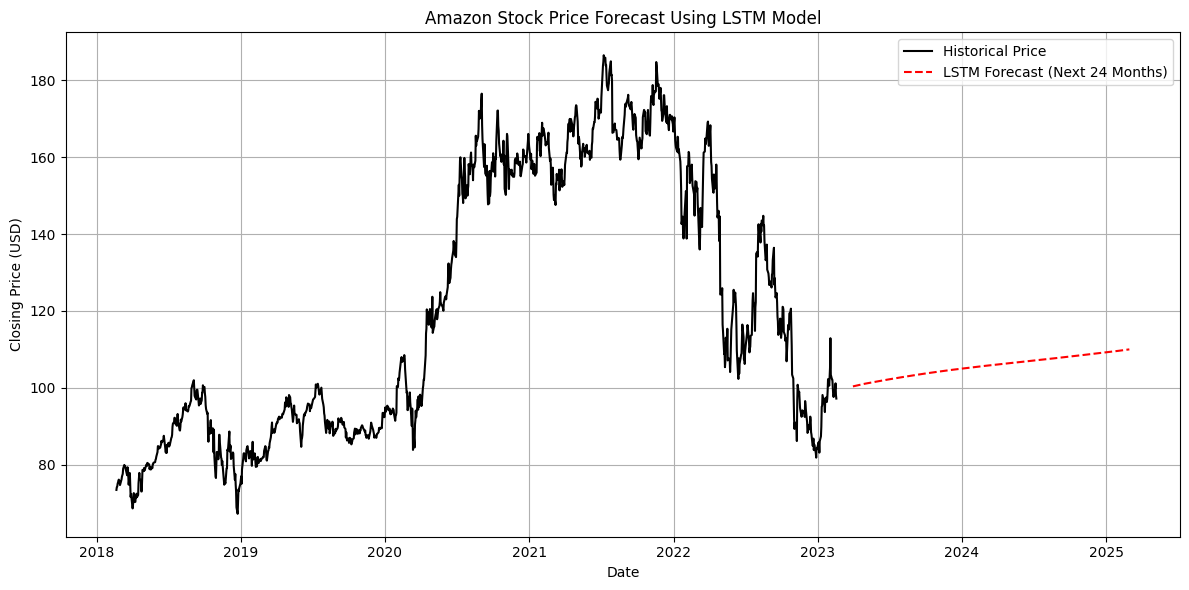

In [ ]:
# Define the number of months to forecast ahead
forecast_horizon = 24

# Start with the last sequence from the test set
last_sequence = X_test[-1].reshape(1, time_window, 1)
future_preds_scaled = []

# Generate future predictions iteratively
for _ in range(forecast_horizon):
    next_pred = model.predict(last_sequence, verbose=0)[0][0]
    future_preds_scaled.append(next_pred)

    # Update the sequence with the new prediction
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse scale to get actual price values
future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))

#  Create future date range
forecast_dates = pd.date_range(start=amzn_data['Date'].iloc[-1], periods=forecast_horizon + 1, freq='M')[1:]

# Plot historical data and LSTM forecast
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Date'], amzn_data['Price'], label='Historical Price', color='black')
plt.plot(forecast_dates, future_preds, label='LSTM Forecast (Next 24 Months)', color='red', linestyle='--')
plt.title('Amazon Stock Price Forecast Using LSTM Model')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Step 15: Evaluate LSTM Model Accuracy**


We evaluate the LSTM model using key statistical metrics:
- **MSE**: Measures average squared error
- **RMSE**: Root of MSE, in the same scale as the target variable
- **MAE**: Measures average magnitude of errors
- **R²**: Indicates how well predictions approximate actual values (1 is perfect)
- **MAPE / sMAPE**: Show average percentage error (good for scale-invariant comparison)

The inverse-scaled `y_test` is used to get real-world values for comparison.


In [ ]:


# Step 1: Inverse transform the scaled y_test
Y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 2: Align predictions and actual values
true_values = Y_test_rescaled
predicted_values = predictions

# Step 3: Compute Evaluation Metrics
mse = mean_squared_error(true_values, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)

# Handle potential divide-by-zero in MAPE/sMAPE
epsilon = 1e-10
mape = np.mean(np.abs((true_values - predicted_values) / (true_values + epsilon))) * 100
smape = np.mean(2 * np.abs(predicted_values - true_values) /
                (np.abs(true_values) + np.abs(predicted_values) + epsilon)) * 100

# Step 4: Display All Metrics
print("LSTM Model Performance on Test Data:")
print(f"🔹 MSE   : {mse:.4f}")
print(f"🔹 RMSE  : {rmse:.4f}")
print(f"🔹 MAE   : {mae:.4f}")
print(f"🔹 R²    : {r2:.4f}")
print(f"🔹 MAPE  : {mape:.2f}%")
print(f"🔹 sMAPE : {smape:.2f}%")


LSTM Model Performance on Test Data:
🔹 MSE   : 21.9372
🔹 RMSE  : 4.6837
🔹 MAE   : 3.7051
🔹 R²    : 0.9544
🔹 MAPE  : 3.22%
🔹 sMAPE : 3.18%


## **Step 16: Compare ARIMA and LSTM Forecasts Against Actual Prices**

This plot compares the actual Amazon stock price (from the test period) with:
- **ARIMA predictions**
- **LSTM predictions**

This allows us to visually assess which model tracks the actual stock movements more accurately during the test set.

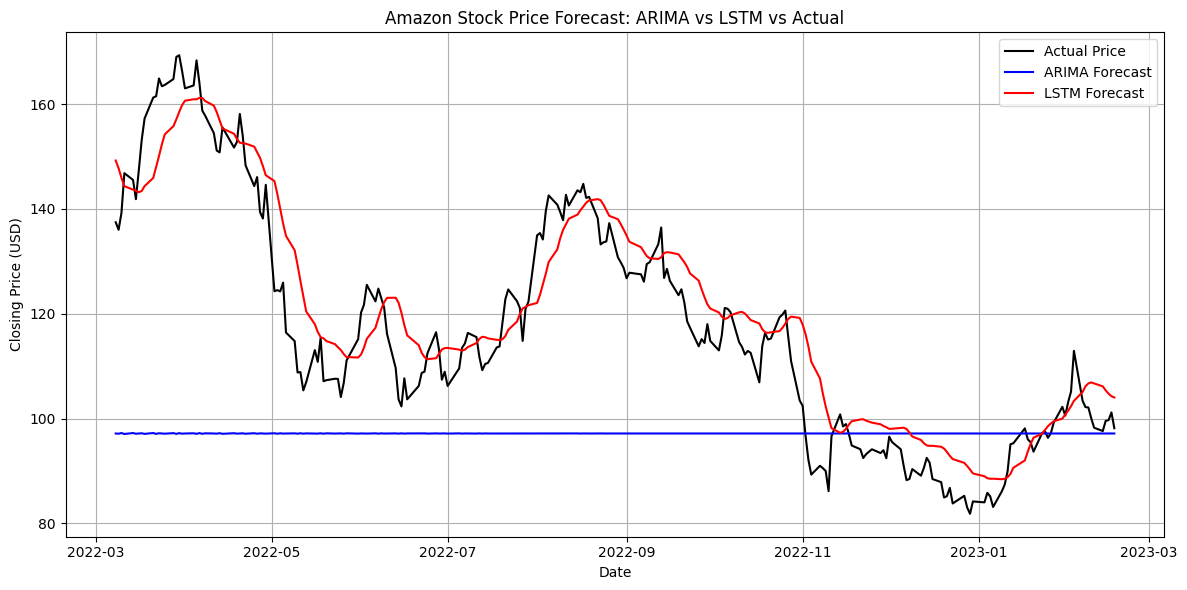

In [ ]:
# Generate ARIMA predictions on the test set
arma_predictions = fitted_model.forecast(steps=len(y_test))  # ARIMA forecast for test set

# Actual test values (already inverse scaled)
true_values = Y_test_rescaled
lstm_predictions = predictions  # LSTM inverse-scaled predictions

# Build proper date index for plotting
plot_index = amzn_data['Date'].iloc[-len(true_values):]

# Plot all three: actual, ARIMA, LSTM
plt.figure(figsize=(12, 6))

plt.plot(plot_index, true_values, label='Actual Price', color='black')
plt.plot(plot_index, arma_predictions, label='ARIMA Forecast', color='blue', linestyle='-')
plt.plot(plot_index, lstm_predictions, label='LSTM Forecast', color='red', linestyle='-')

plt.title('Amazon Stock Price Forecast: ARIMA vs LSTM vs Actual')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Step 17: Visualize Future Forecast (ARIMA vs LSTM)**

We forecast Amazon’s stock price for the next 24 months using:
- The trained ARIMA model (`.forecast()`)
- The LSTM model (by predicting step-by-step using the last known sequence)

Both forecasts are plotted along with the historical data for context.
This visual helps compare the two models' ability to capture future stock movement trends.


<ipython-input-36-a1a598a34c6c>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=amzn_data['Date'].iloc[-1], periods=25, freq='M')[1:]


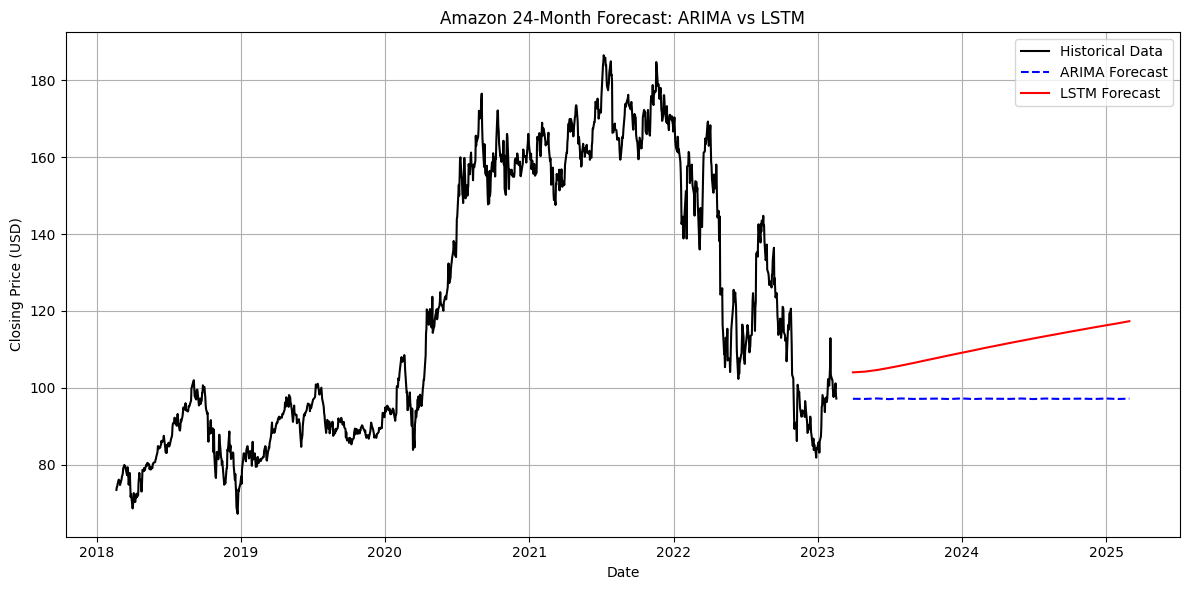

In [ ]:
# ARIMA forecast (already computed)
arma_forecast = fitted_model.forecast(steps=24)

# LSTM forecast (already inverse-scaled)
lstm_forecast = future_preds  # from Step 14

# Generate datetime index for future 24 months
forecast_dates = pd.date_range(start=amzn_data['Date'].iloc[-1], periods=25, freq='M')[1:]

# Plot forecasts alongside historical data
plt.figure(figsize=(12, 6))

# Historical actual data
plt.plot(amzn_data['Date'], amzn_data['Price'], label='Historical Data', color='black')

# Forecast from ARIMA
plt.plot(forecast_dates, arma_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# Forecast from LSTM
plt.plot(forecast_dates, lstm_forecast, label='LSTM Forecast', color='red', linestyle='-')

plt.title('Amazon 24-Month Forecast: ARIMA vs LSTM')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ***LSTM outperformed ARIMA in predicting Amazon stock prices, especially in capturing the underlying trend and minimizing squared errors.***